In [1]:
import numpy as np
from utils import draw_boxes, unbox
import json
from PIL import Image, ImageFont, ImageDraw
from PID import PID
import glob
import os
import time
import cv2


## Preprocessing
We store some images from the thymio so we can use them to locally test the logic behind the code that we will run on the thymio

In [2]:
def get_n(x):
    n = x.split('/')[-1].split('.')[0]
    return int(n)

In [3]:
images_path = sorted(glob.glob('./image_save/*.npy'), key=get_n)
datas_path = sorted(glob.glob('./image_save/*.json'), key=get_n)
paths = list(zip(images_path, datas_path))
paths

[]

In [7]:
TARGET = 'person'

In [8]:
def load_from_path(paths):
    img_path, data_path = paths
    img = np.load(img_path)
    data = json.load(open(data_path, 'r'))
    
    return img, data['res']

In [9]:
dataset = list(map(load_from_path, paths))

In [10]:
width, height, colors = dataset[0][0].shape

In [11]:
print("image size: {},{}".format(width, height))

image size: 480,640


In [12]:
def is_target_in_img(data, target):
    filtered = list(filter(lambda x: x['class'] == target, data))
    return len(filtered) > 0

In [13]:
def get_class_data(data, class_name):
    filtered = list(filter(lambda x: x['class'] == class_name, data))
    
    return None if len(filtered) <= 0 else filtered[0]

In [14]:
def get_box(data, class_name):
    data = get_class_data(data, class_name)
    box = np.array(data['boxes'])
    box[box < 0] = 0 #prune negative
    return box

## How far we are from the object
New we need to calculate the mid point y of the rectangle in order to find out how much we are far from the center

In [15]:
img_mid_p = width // 2
img_mid_p

240

In [16]:
top, left, bottom, right = dataset[0][1][0]['boxes']
top, left, bottom, right 

(148.19534301757812, 135.91024780273438, 204.44972229003906, 150.40576171875)

### How many  leds to turn on
on the thymio we hade 5 leds

In [17]:
N_LEDS = 5

In [18]:
led_mask = np.zeros(N_LEDS)

we need to find out how many % the rectangular is in the img

In [19]:
(left / width / 100) * N_LEDS
((right / width) / 100) * N_LEDS

0.015667266845703125

In [20]:
start_led = int(((left / width) / 100) * N_LEDS * 100)
end_led = int(((right / width) / 100) * N_LEDS * 100)
start_led, end_led

(1, 1)

In [21]:
led_mask[start_led:end_led] = 1

In [22]:
led_mask

array([0., 0., 0., 0., 0.])

In [23]:
def get_err(box):
    top, left, bottom, right = box
    target_mid_p = np.abs(left - right) / 2
    offset = (left + target_mid_p)
    print(offset)
    err = offset - img_mid_p
    return err

In [24]:
angular_pid = PID(Kd=5, Ki=0, Kp=0.1)

In [25]:
for img, data in dataset:
    if is_target_in_img(data, TARGET):
        img = Image.fromarray(np.roll(img, 1, axis=-1))
        img.show()
        box = get_box(data, TARGET)
        err = get_err(box)
        ang_vel = angular_pid.step(err, 1)
#         print('mid p:',img_mid_p)
        print("err:", err)
        print("vel:", ang_vel)

        img.close()
        time.sleep(0.3)

41.98937225341797
err: -198.01062774658203
vel: -19.801062774658206
112.7409553527832
err: -127.2590446472168
vel: 341.0320110321045
190.70595169067383
err: -49.29404830932617
vel: 384.8955768585205
249.20473098754883
err: 9.204730987548828
vel: 293.4143695831299
241.51050567626953
err: 1.5105056762695312
vel: -38.32007598876953
324.3134994506836
err: 84.3134994506836
vel: 422.44631881713866


## Real data from the Thymio

In [7]:
import matplotlib.pyplot as plt

In [8]:
err = [-0.599661126236,-0.577736361821,-0.562375926971,-0.550064325333,-0.541476583481,-0.516269297401,-0.479043871164,-0.453105874856,-0.426700818539,-0.38413563172,-0.342431433996,-0.31088681221,-0.278597942988,-0.237514273326,-0.202485402425,-0.168962160746,-0.125017563502,-0.0914477030436,-0.0555149237315,-0.0287092844645,0.0107469558716,0.0504107475281,0.0834788958232,0.115181223551,0.145635414124,0.187940597534,0.222352981567,0.250846163432,0.328469435374,0.37017065684,0.389235782623,0.434866078695,0.472462368011,0.503446102142,0.524384562174,0.551801300049,0.569025103251,0.583710988363,]

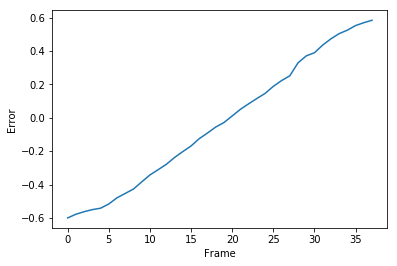

In [11]:
fig = plt.figure()
plt.plot(err)
plt.ylabel('Error')
plt.xlabel('Frame')
plt.show()
fig.savefig('../../paper/images/frame_error.png', dpi=300)

## Create a Video

In [22]:
images = glob.glob('./image_save/*.jpg')

images.sort(key=get_n)

['./image_save/1.jpg',
 './image_save/2.jpg',
 './image_save/3.jpg',
 './image_save/4.jpg',
 './image_save/6.jpg',
 './image_save/11.jpg',
 './image_save/12.jpg',
 './image_save/13.jpg',
 './image_save/14.jpg',
 './image_save/15.jpg',
 './image_save/16.jpg',
 './image_save/17.jpg',
 './image_save/18.jpg',
 './image_save/20.jpg',
 './image_save/21.jpg',
 './image_save/23.jpg',
 './image_save/24.jpg',
 './image_save/26.jpg',
 './image_save/27.jpg',
 './image_save/28.jpg',
 './image_save/29.jpg',
 './image_save/31.jpg',
 './image_save/32.jpg',
 './image_save/34.jpg',
 './image_save/35.jpg',
 './image_save/36.jpg',
 './image_save/37.jpg',
 './image_save/38.jpg',
 './image_save/39.jpg',
 './image_save/40.jpg',
 './image_save/41.jpg',
 './image_save/42.jpg',
 './image_save/43.jpg',
 './image_save/44.jpg',
 './image_save/45.jpg',
 './image_save/46.jpg',
 './image_save/47.jpg',
 './image_save/48.jpg',
 './image_save/111.jpg',
 './image_save/112.jpg',
 './image_save/113.jpg',
 './image_save/114

In [26]:
list(filter(lambda x: x[1] == './image_save/296.jpg', enumerate(images)))

[(82, './image_save/296.jpg')]

In [27]:
video_img = images[82:]


In [50]:
img = cv2.imread(video_img[0])
height, width, layers =  img.shape
print(width, height)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video = cv2.VideoWriter('video.gif',fourcc, 20.0,(width,height))

for img in video_img:
    img = cv2.imread(img)
    video.write(img.astype('uint8'))
# video.write(img1)
# video.write(img2)
# video.write(img3)

cv2.destroyAllWindows()
video.release()

640 480
